In [1]:
import os
os.environ["SNUDDA_DATA"] = "../../../../BasalGangliaData/data/"
assert os.path.isdir(os.getenv("SNUDDA_DATA")), f"You need to have BasalGangliaData installed for this example. You can run this example without it, but then do not execute this cell."

In [2]:
network_path = "FS_gap_junction_coupling_simulation"
experiment_config_file = "FS_gap_junction_experiment-0.json"

In [ ]:
# 80500 neurons per mm3, 1.3% are FS.
n_FS = 10
d_cube = (100/80500)**(1/3) * 1e-3

from snudda.place import create_cube_mesh
mesh_file = os.path.join(network_path, "mesh", "volume.obj")
create_cube_mesh(mesh_file, [0,0,0], d_cube, "FS network volume")

In [ ]:
from snudda.init import SnuddaInit
si = SnuddaInit(network_path=network_path, random_seed=123)

si.define_structure(struct_name="StriatalVolume", struct_mesh=mesh_file, d_min=15e-6, mesh_bin_width=50e-6)

si.add_neurons(name="FS", num_neurons=n_FS, volume_id="StriatalVolume",
               neuron_dir=os.path.join("$SNUDDA_DATA","neurons","striatum","fs"))

cluster_FS_synapses = True
cluster_FS_gap_junctions = False
FS_gGABA = [1.1e-9, 1.5e-9]
FS_gGapJunction = [0.5e-9, 0.1e-9]

if False:
    # For this example we just want gap junctions, just listing GABA here for completness
    si.add_neuron_target(neuron_name="FS",
                         target_name="FS",
                         connection_type="GABA",
                         dist_pruning=None,
                         f1=0.15, soft_max=5, mu2=2, a3=1,
                         conductance=FS_gGABA,
                         cluster_synapses=cluster_FS_synapses,
                         mod_file="tmGabaA",
                         channel_param_dictionary={"tau1": (1.33e-3, 1e3),
                                                   "tau2": (5.7e-3, 1e3)})
    
si.add_neuron_target(neuron_name="FS",
                     target_name="FS",
                     connection_type="GapJunction",
                     dist_pruning=None,
                     f1=0.7, soft_max=8, mu2=2, a3=1.0,
                     conductance=FS_gGapJunction,
                     cluster_synapses=cluster_FS_gap_junctions,
                     channel_param_dictionary=None)

si.write_json()

In [ ]:
from snudda.place import SnuddaPlace
sp = SnuddaPlace(network_path=network_path)
sp.place()

from snudda.detect import SnuddaDetect
sd = SnuddaDetect(network_path=network_path)
sd.detect()

from snudda.detect import SnuddaPrune
spr = SnuddaPrune(network_path=network_path)
spr.prune()

In [ ]:
!nrnivmodl $SNUDDA_DATA/neurons/mechanisms

In [ ]:
from snudda.simulate.pair_recording import PairRecording

pr = PairRecording(network_path=network_path, experiment_config_file=experiment_config_file)
pr.run()

In [3]:
from snudda.analyse.analyse_gap_junction_coupling import AnalyseGapJunctionCoupling
ac = AnalyseGapJunctionCoupling(network_path=network_path, 
                                experiment_config_file=experiment_config_file)

Loading 10 neurons with 0 synapses and 133 gap junctions
Loading FS_gap_junction_coupling_simulation/simulation/FS-gap-junction-output.hdf5


In [4]:
coupling, trace_info = ac.extract_coupling()

In [5]:
coupling, trace_info = ac.extract_coupling(duration=0.010)

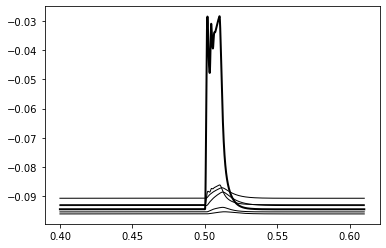

In [6]:
ac.plot_coupling(duration=0.010, amplitude=None)